In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
import pandas as pd

# Cargar datos
df = pd.read_csv("daily_occupancy.csv")
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')
df.set_index('fecha', inplace=True)

# Solo nos quedamos con la columna ocupacion
serie = df['ocupacion']

# Definir tamaño del set de prueba
horizonte = 30
train = serie.iloc[:-horizonte]
test = serie.iloc[-horizonte:]

print(f"Train: {train.index.min()} → {train.index.max()}")
print(f"Test: {test.index.min()} → {test.index.max()}")

Train: 2019-02-13 00:00:00 → 2020-02-12 00:00:00
Test: 2020-02-13 00:00:00 → 2020-03-13 00:00:00


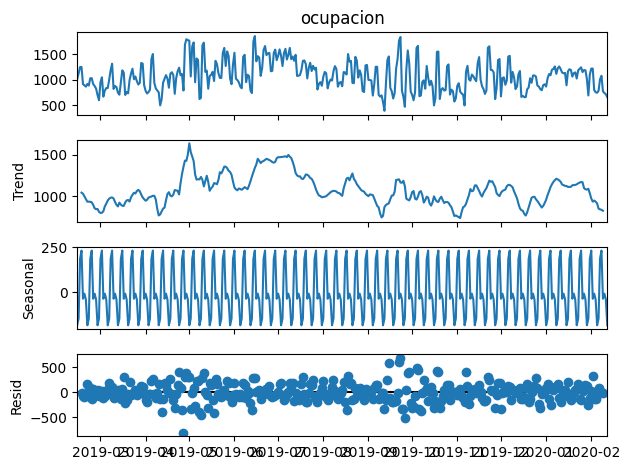

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Aplicamos la descomposición (modo aditivo)
descomposicion = seasonal_decompose(train, model='add', period=7)  # Asumimos patrón semanal

# Graficamos los componentes
descomposicion.plot()
plt.tight_layout()
# plt.savefig("holt-winters_decomposition.png")
plt.show()

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# parametros del modelo
trend = "mul"
seasonal_periods = 14
seasonal = 'mul'

# Entrenamos el modelo Holt-Winters con estacionalidad aditiva
modelo_hw = ExponentialSmoothing(
    train,
    trend=trend, # tendencia de la serie (sube, baja o no hay)  
    seasonal=seasonal, # tipo de estacionalidad (aditiva o multiplicativa)
    seasonal_periods=seasonal_periods # cuantos periodos tarda en repetirse el patrón seasonal     
).fit()

predicciones_hw = modelo_hw.forecast(steps=horizonte)
predicciones_hw.index = test.index

MAE  = 137.63
RMSE = 159.34
MPE  = 14.37%


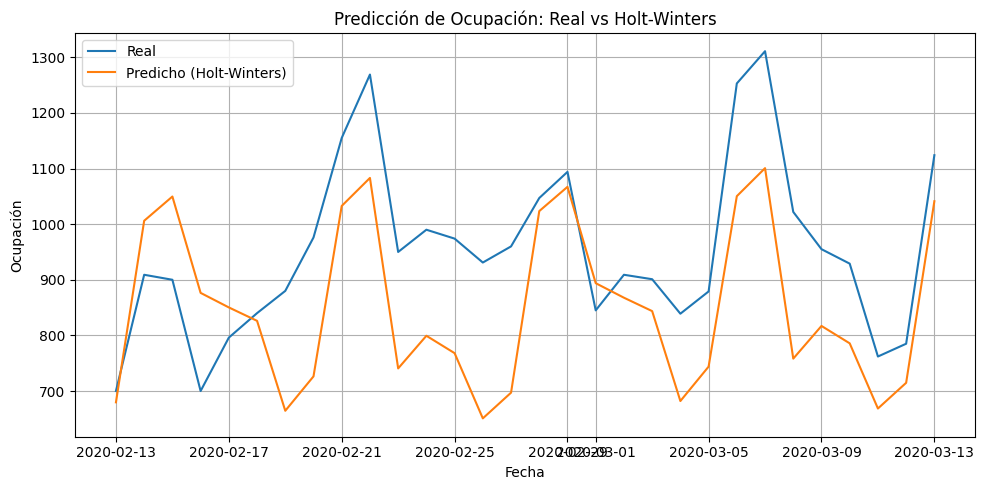

In [31]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt

# Métricas de desempeño
mae = mean_absolute_error(test, predicciones_hw)
rmse = root_mean_squared_error(test, predicciones_hw)
mpe = ((test - predicciones_hw) / test).abs().mean() * 100

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MPE  = {mpe:.2f}%")

# Gráfica: comparación real vs predicho
plt.figure(figsize=(10, 5))
plt.plot(test, label='Real')
plt.plot(predicciones_hw, label='Predicho (Holt-Winters)')
plt.title('Predicción de Ocupación: Real vs Holt-Winters')
plt.xlabel('Fecha')
plt.ylabel('Ocupación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("holt-winters_forecast.png")
plt.show()

In [32]:
# Set tracking URI and experiment
import mlflow.statsmodels
from mlflow.models import infer_signature

mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("Oumaji_Occupancy")

# Log params, metrics, insights.
# La signature es lo que el modelo espera (que input recibe) y lo que produce (output que genera)
signature = infer_signature(train.to_frame(), modelo_hw.forecast(steps=horizonte))

# Log with MLflow
with mlflow.start_run():    
    # Parametros del modelo
    mlflow.log_param("horizonte", horizonte)
    mlflow.log_param("trend", trend)
    mlflow.log_param("seasonal", seasonal)
    mlflow.log_param("seasonal_periods", seasonal_periods)

    # Métricas
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MPE", mpe)
    mlflow.log_metric("RMSE", rmse)

    # Artifactos
    mlflow.log_artifact("holt-winters_forecast.png", artifact_path="plots")

    # registrar modelo
    mlflow.statsmodels.log_model(modelo_hw, "model", 
                                registered_model_name="HOLT-WINTERS", 
                                signature=signature)

2025/05/22 08:38:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'HOLT-WINTERS' already exists. Creating a new version of this model...
2025/05/22 08:38:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: HOLT-WINTERS, version 2


🏃 View run gentle-wasp-285 at: http://localhost:5001/#/experiments/176230793224478268/runs/ff6b7a6e6a9b4f03a0f61bcfbefbb631
🧪 View experiment at: http://localhost:5001/#/experiments/176230793224478268


Created version '2' of model 'HOLT-WINTERS'.
